In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, solve_bvp
from matplotlib.lines import Line2D

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

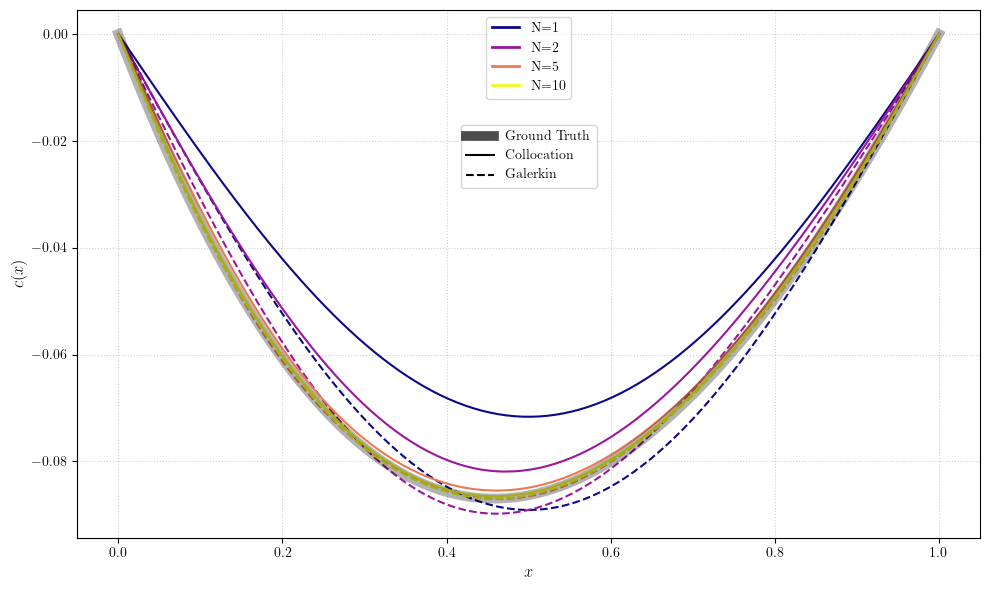

In [2]:
# ground truth using solve_bvp (i acknowledge this is not the best way to do this)
def fun(x, y):
    # system of 1st order equations:
    # y[0] = c, y[1] = c'
    # c'' = c + exp(-x^2)  =>  y[1]' = y[0] + exp(-x^2)
    return np.vstack((y[1], y[0] + np.exp(-x**2)))

def bc(ya, yb):
    # BCs: c(0) = 0, c(1) = 0
    return np.array([ya[0], yb[0]])

x_init = np.linspace(0, 1, 20)
y_init = np.zeros((2, x_init.size))

res = solve_bvp(fun, bc, x_init, y_init, tol=1e-8)

N_values = [1, 2, 5, 10]
x_dense = np.linspace(0, 1, 200)
y_gt = res.sol(x_dense)[0]

plt.figure(figsize=(10, 6))

colors = plt.cm.plasma(np.linspace(0, 1, len(N_values)))

# Galerkin and collocation
for idx, N in enumerate(N_values):
    color = colors[idx]
    
    c_galerkin = np.zeros(N)
    for j in range(1, N + 1):
        integrand = lambda x: np.exp(-x**2) * np.sin(j * np.pi * x)
        integral_val, _ = quad(integrand, 0, 1)
        
        c_galerkin[j-1] = (integral_val) / (0.5 * (-(j * np.pi)**2 - 1))

    y_galerkin = np.zeros_like(x_dense)
    for j in range(1, N + 1):
        y_galerkin += c_galerkin[j-1] * np.sin(j * np.pi * x_dense)
        
    xi = np.linspace(0, 1, N + 2)[1:-1]
    
    A = np.zeros((N, N))
    b = np.exp(-xi**2)
    
    for row in range(N): 
        for col in range(N): 
            j = col + 1
            x_val = xi[row]
            
            val = -((j * np.pi)**2 + 1) * np.sin(j * np.pi * x_val)
            A[row, col] = val
            
    c_collocation = np.linalg.solve(A, b)
    
    y_collocation = np.zeros_like(x_dense)
    for j in range(1, N + 1):
        y_collocation += c_collocation[j-1] * np.sin(j * np.pi * x_dense)

    plt.plot(x_dense, y_collocation, color=color, linestyle='-', 
                linewidth=1.5)
    plt.plot(x_dense, y_galerkin, color=color, linestyle='--', 
                linewidth=1.5)

plt.plot(x_dense, y_gt, color='k', linewidth=7, alpha=0.3, label='Ground Truth')


plt.xlabel('$x$', fontsize=12)
plt.ylabel('$c(x)$', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)

custom_lines = [Line2D([0], [0], color='k', lw=7, alpha=0.7),
                Line2D([0], [0], color='black', lw=1.5, linestyle='-'),
                Line2D([0], [0], color='black', lw=1.5, linestyle='--')]

first_legend = plt.legend(custom_lines, ['Ground Truth', 'Collocation', 'Galerkin'], 
                        loc='lower center', bbox_to_anchor=(0.5, 0.65))
plt.gca().add_artist(first_legend)

color_lines = [Line2D([0], [0], color=c, lw=2) for c in colors]
plt.legend(color_lines, [f'N={n}' for n in N_values], loc='upper center')

plt.tight_layout()
plt.savefig("../../../figs/ode/bvp_coll_galerkin.pdf", bbox_inches="tight", transparent=True)
plt.show()